In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os
import glob
from PIL import Image
import math
print("Libraries imported successfully!")
print("NumPy version:", np.__version__)
print("OpenCV version:", cv2.__version__)

Libraries imported successfully!
NumPy version: 1.26.4
OpenCV version: 4.12.0


Q1

In [ ]:
# PART 1: INTEGRAL IMAGE COMPUTATION AND VERIFICATION

class IntegralImageProcessor:
    def compute_integral_image(self, image):
        """Compute integral image representation"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        image = image.astype(np.float64)
        row_cumsum = np.cumsum(image, axis=1)
        integral_img = np.cumsum(row_cumsum, axis=0)
        return integral_img

    def compute_region_sum(self, integral_image, x1, y1, x2, y2):
        """Compute sum of pixels in rectangular region using integral image"""
        A = integral_image[y1-1, x1-1] if y1 > 0 and x1 > 0 else 0
        B = integral_image[y1-1, x2] if y1 > 0 else 0
        C = integral_image[y2, x1-1] if x1 > 0 else 0
        D = integral_image[y2, x2]
        return D - B - C + A

    def verify_integral_image(self, original_image, integral_image, x1, y1, x2, y2):
        """Verify integral image correctness"""
        if len(original_image.shape) == 3:
            original_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
        else:
            original_gray = original_image

        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(original_gray.shape[1]-1, x2), min(original_gray.shape[0]-1, y2)

        integral_sum = self.compute_region_sum(integral_image, x1, y1, x2, y2)
        region = original_gray[y1:y2+1, x1:x2+1]
        direct_sum = np.sum(region)

        print(f"Region ({x1},{y1}) to ({x2},{y2}): Integral={integral_sum:.2f}, Direct={direct_sum:.2f}, Diff={abs(integral_sum - direct_sum):.6f}")
        return abs(integral_sum - direct_sum) < 1e-6

    def create_sample_image(self, size=256):
        """Create sample test image"""
        image = np.zeros((size, size), dtype=np.uint8)
        for i in range(0, size, 40):
            for j in range(0, size, 40):
                intensity = (i + j) % 256
                image[i:i+20, j:j+20] = intensity
        x = np.linspace(0, 255, size)
        y = np.linspace(0, 255, size)
        X, Y = np.meshgrid(x, y)
        gradient = (X + Y) / 2
        image = np.clip(image + gradient.astype(np.uint8), 0, 255)
        return image

    def visualize_integral_image(self, original, integral):
        """Visualize original and integral images"""
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        axes[0].imshow(original, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        im = axes[1].imshow(integral, cmap='hot')
        axes[1].set_title('Integral Image')
        axes[1].axis('off')
        plt.colorbar(im, ax=axes[1])

        plt.tight_layout()
        plt.show()

    def run(self):
        print("INTEGRAL IMAGE")

        test_image = self.create_sample_image()
        print(f"Image shape: {test_image.shape}")

        integral_img = self.compute_integral_image(test_image)

        # Verification on multiple regions
        test_regions = [(10, 10, 50, 50), (30, 30, 100, 100), (0, 0, 99, 99)]
        for region in test_regions:
            self.verify_integral_image(test_image, integral_img, *region)

        self.visualize_integral_image(test_image, integral_img)
        return test_image, integral_img

INTEGRAL IMAGE
Image shape: (256, 256)
Region (10,10) to (50,50): Integral=68490.00, Direct=68490.00, Diff=0.000000
Region (30,30) to (100,100): Integral=511237.00, Direct=511237.00, Diff=0.000000
Region (0,0) to (99,99): Integral=773332.00, Direct=773332.00, Diff=0.000000


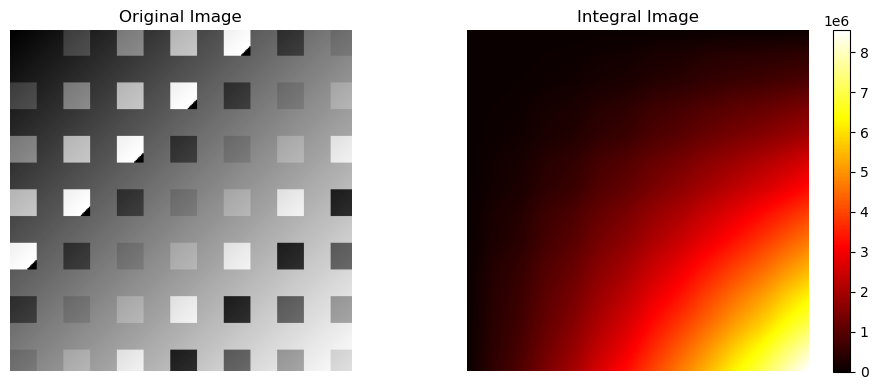

HAAR-LIKE FEATURES
Filter size: 24x24
Center region: 50x50 pixels

Total features: 784
Features per pattern: 196
Min: -5248.00, Max: 26368.00, Mean: 5171.51


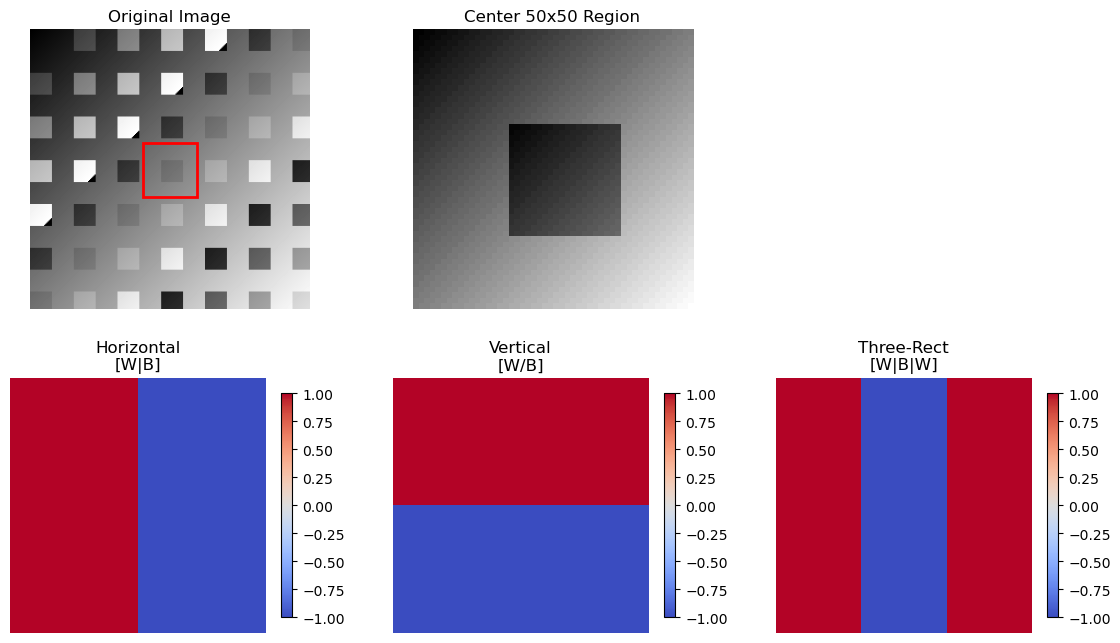

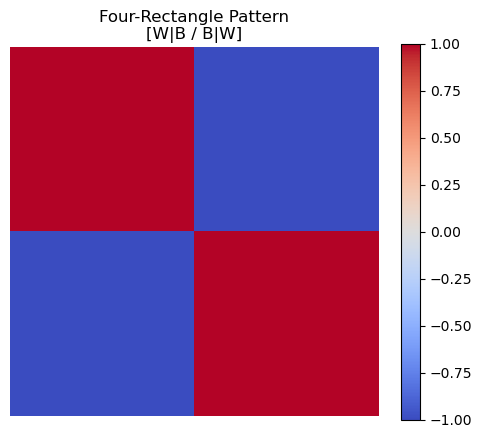

In [ ]:
# PART 2: HAAR-LIKE FEATURE EXTRACTION

class HaarFeatureExtractor:
    def compute_integral_image(self, image):
        """Compute integral image"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image.astype(np.float64)
        row_cumsum = np.cumsum(image, axis=1)
        return np.cumsum(row_cumsum, axis=0)

    def compute_region_sum(self, integral_image, x1, y1, x2, y2):
        """Compute region sum"""
        A = integral_image[y1-1, x1-1] if y1 > 0 and x1 > 0 else 0
        B = integral_image[y1-1, x2] if y1 > 0 else 0
        C = integral_image[y2, x1-1] if x1 > 0 else 0
        D = integral_image[y2, x2]
        return D - B - C + A

    def extract_haar_features(self, image, filter_size=24):
        """Extract Haar features from center 50x50 region"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        h, w = image.shape
        integral_img = self.compute_integral_image(image)

        # Center 50x50 region
        center_h, center_w = h // 2, w // 2
        start_h, end_h = center_h - 25, center_h + 25
        start_w, end_w = center_w - 25, center_w + 25

        def haar_horizontal_lr(integral, x, y, size):
            """Horizontal: [White | Black]"""
            half = size // 2
            white = self.compute_region_sum(integral, x, y, x+half-1, y+size-1)
            black = self.compute_region_sum(integral, x+half, y, x+size-1, y+size-1)
            return white - black

        def haar_vertical_tb(integral, x, y, size):
            """Vertical: [White / Black]"""
            half = size // 2
            white = self.compute_region_sum(integral, x, y, x+size-1, y+half-1)
            black = self.compute_region_sum(integral, x, y+half, x+size-1, y+size-1)
            return white - black

        def haar_three_horizontal(integral, x, y, size):
            """Three-rectangle: [W | B | W]"""
            third = size // 3
            w1 = self.compute_region_sum(integral, x, y, x+third-1, y+size-1)
            b = self.compute_region_sum(integral, x+third, y, x+2*third-1, y+size-1)
            w2 = self.compute_region_sum(integral, x+2*third, y, x+size-1, y+size-1)
            return (w1 + w2) - b

        def haar_four_rectangle(integral, x, y, size):
            """Four-rectangle: [W|B / B|W]"""
            half = size // 2
            w1 = self.compute_region_sum(integral, x, y, x+half-1, y+half-1)
            b1 = self.compute_region_sum(integral, x+half, y, x+size-1, y+half-1)
            b2 = self.compute_region_sum(integral, x, y+half, x+half-1, y+size-1)
            w2 = self.compute_region_sum(integral, x+half, y+half, x+size-1, y+size-1)
            return (w1 + w2) - (b1 + b2)

        haar_features = []

        for i in range(0, 50 - filter_size + 1, 2):
            for j in range(0, 50 - filter_size + 1, 2):
                x, y = start_w + j, start_h + i
                f1 = haar_horizontal_lr(integral_img, x, y, filter_size)
                f2 = haar_vertical_tb(integral_img, x, y, filter_size)
                f3 = haar_three_horizontal(integral_img, x, y, filter_size)
                f4 = haar_four_rectangle(integral_img, x, y, filter_size)
                haar_features.extend([f1, f2, f3, f4])

        return np.array(haar_features)

    def visualize_haar_patterns(self, image, filter_size=24):
        """Visualize Haar patterns"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        h, w = image.shape
        center_h, center_w = h // 2, w // 2

        fig, axes = plt.subplots(2, 3, figsize=(14, 8))

        # Original with center marked
        axes[0, 0].imshow(image, cmap='gray')
        axes[0, 0].set_title('Original Image')
        rect = plt.Rectangle((center_w-25, center_h-25), 50, 50,
                           fill=False, edgecolor='red', linewidth=2)
        axes[0, 0].add_patch(rect)
        axes[0, 0].axis('off')

        # Center region
        center_region = image[center_h-25:center_h+25, center_w-25:center_w+25]
        axes[0, 1].imshow(center_region, cmap='gray')
        axes[0, 1].set_title('Center 50x50 Region')
        axes[0, 1].axis('off')

        axes[0, 2].axis('off')

        # Haar patterns
        half = filter_size // 2
        third = filter_size // 3

        # Pattern 1: Horizontal [W|B]
        p1 = np.zeros((filter_size, filter_size))
        p1[:, :half] = 1
        p1[:, half:] = -1

        # Pattern 2: Vertical [W/B]
        p2 = np.zeros((filter_size, filter_size))
        p2[:half, :] = 1
        p2[half:, :] = -1

        # Pattern 3: Three horizontal [W|B|W]
        p3 = np.zeros((filter_size, filter_size))
        p3[:, :third] = 1
        p3[:, third:2*third] = -1
        p3[:, 2*third:] = 1

        # Pattern 4: Four rectangle [W|B / B|W]
        p4 = np.zeros((filter_size, filter_size))
        p4[:half, :half] = 1
        p4[:half, half:] = -1
        p4[half:, :half] = -1
        p4[half:, half:] = 1

        patterns = [
            ('Horizontal\n[W|B]', p1),
            ('Vertical\n[W/B]', p2),
            ('Three-Rect\n[W|B|W]', p3),
            ('Four-Rect\n[W|B/B|W]', p4)
        ]

        for idx, (title, pattern) in enumerate(patterns[:3]):
            im = axes[1, idx].imshow(pattern, cmap='coolwarm', vmin=-1, vmax=1)
            axes[1, idx].set_title(title)
            axes[1, idx].axis('off')
            plt.colorbar(im, ax=axes[1, idx], shrink=0.8)

        # Add 4th pattern separately
        fig2, ax = plt.subplots(1, 1, figsize=(5, 5))
        im = ax.imshow(p4, cmap='coolwarm', vmin=-1, vmax=1)
        ax.set_title('Four-Rectangle Pattern\n[W|B / B|W]')
        ax.axis('off')
        plt.colorbar(im, ax=ax, shrink=0.8)

        plt.tight_layout()
        plt.show()

    def run(self, image):
        print("HAAR-LIKE FEATURES")

        filter_size = 24
        print(f"Filter size: {filter_size}x{filter_size}")
        print(f"Center region: 50x50 pixels")

        haar_features = self.extract_haar_features(image, filter_size)
        print(f"\nTotal features: {len(haar_features)}")
        print(f"Features per pattern: {len(haar_features) // 4}")
        print(f"Min: {haar_features.min():.2f}, Max: {haar_features.max():.2f}, Mean: {haar_features.mean():.2f}")

        self.visualize_haar_patterns(image, filter_size)
        return haar_features


# Execute
processor = IntegralImageProcessor()
test_image, integral_image = processor.run()

extractor = HaarFeatureExtractor()
haar_features = extractor.run(test_image)


Q2

In [ ]:
class TextureClassifier:
    def __init__(self, data_path):
        """Initialize classifier with dataset path and class names"""
        self.data_path = data_path
        self.classes = ['aluminium_foil', 'brown_bread', 'corduroy', 'cotton', 'cracker',
                       'linen', 'orange_peel', 'sandpaper', 'sponge', 'styrofoam']
        self.class_map = {class_name: idx for idx, class_name in enumerate(self.classes)}

    def resize_image(self, img_array, target_size=(200, 200)):
        """Resize image to target size using bilinear interpolation"""
        h, w = img_array.shape
        new_h, new_w = target_size

        # Create new image
        resized = np.zeros(target_size, dtype=img_array.dtype)

        # Calculate scaling factors
        scale_x = w / new_w
        scale_y = h / new_h

        for i in range(new_h):
            for j in range(new_w):
                # Map new coordinates to original
                x = j * scale_x
                y = i * scale_y

                # Bilinear interpolation
                x1, y1 = int(np.floor(x)), int(np.floor(y))
                x2, y2 = min(x1 + 1, w - 1), min(y1 + 1, h - 1)

                dx = x - x1
                dy = y - y1

                # Interpolate
                resized[i, j] = (1 - dx) * (1 - dy) * img_array[y1, x1] + \
                               dx * (1 - dy) * img_array[y1, x2] + \
                               (1 - dx) * dy * img_array[y2, x1] + \
                               dx * dy * img_array[y2, x2]

        return resized

    def load_dataset(self, target_size=(200, 200)):
        """
        Load KTH-TIPS dataset
        Resizes all images to fixed size for consistency
        Returns images and labels as numpy arrays
        """
        images = []
        labels = []

        print("Loading KTH-TIPS dataset...")
        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(self.data_path, class_name)

            if not os.path.exists(class_path):
                print(f"Warning: Directory not found - {class_path}")
                continue

            image_files = glob.glob(os.path.join(class_path, "*.png"))
            print(f"Found {len(image_files)} images in {class_name}")

            for img_path in image_files:
                try:
                    # Load image and convert to grayscale
                    img = Image.open(img_path).convert('L')
                    img_array = np.array(img, dtype=np.float32)

                    # Resize to target size if needed
                    if img_array.shape != target_size:
                        img_resized = self.resize_image(img_array, target_size)
                    else:
                        img_resized = img_array

                    # Normalize pixel values to [0, 1]
                    img_normalized = img_resized / 255.0
                    images.append(img_normalized)
                    labels.append(class_idx)

                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

        print(f"\nSuccessfully loaded {len(images)} images from {len(set(labels))} classes")

        # Convert to numpy arrays
        images_array = np.array(images)
        labels_array = np.array(labels)

        print(f"Final image array shape: {images_array.shape}")
        return images_array, labels_array

# Initialize and load dataset
data_path = r"C:\Users\SUSHOVIT\OneDrive\Desktop\KTH_TIPS"
classifier = TextureClassifier(data_path)
images, labels = classifier.load_dataset(target_size=(200, 200))

Loading KTH-TIPS dataset...
Found 81 images in aluminium_foil
Found 81 images in brown_bread
Found 81 images in corduroy
Found 81 images in cotton
Found 81 images in cracker
Found 81 images in linen
Found 81 images in orange_peel
Found 81 images in sandpaper
Found 81 images in sponge
Found 81 images in styrofoam

Successfully loaded 810 images from 10 classes
Final image array shape: (810, 200, 200)


In [ ]:
def raw_pixel_classification(self, images, labels):
    """
    2(i): Train and evaluate SVM classifier using raw pixel intensity values
    Images are flattened to 1D vectors and used as features
    """
    print("2(i): RAW PIXEL INTENSITY CLASSIFICATION")

    # Flatten images to 1D feature vectors (200x200 = 40,000 features per image)
    X = images.reshape(images.shape[0], -1)
    y = labels

    print(f"Feature dimensions: {X.shape[1]} features per image")
    print(f"Total samples: {X.shape[0]}")

    # Split dataset: 70% training, 30% testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

    # Standardize features to zero mean and unit variance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train SVM classifier with linear kernel
    clf = svm.SVC(kernel='linear', random_state=42)
    clf.fit(X_train_scaled, y_train)

    # Evaluate classifier performance
    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\nAccuracy: {accuracy:.4f}")
    return accuracy

# Add method to class and execute
TextureClassifier.raw_pixel_classification = raw_pixel_classification
acc_raw = classifier.raw_pixel_classification(images, labels)

2(i): RAW PIXEL INTENSITY CLASSIFICATION
Feature dimensions: 40000 features per image
Total samples: 810
Training samples: 567, Test samples: 243

Accuracy: 0.4239


In [ ]:
def compute_lbp(self, image, P=8, R=1):
    """
    Compute Local Binary Pattern from scratch
    P: Number of neighboring points
    R: Radius of circular neighborhood
    Returns LBP encoded image
    """
    height, width = image.shape
    lbp = np.zeros((height, width), dtype=np.uint8)

    # Process each pixel (excluding borders)
    for i in range(R, height - R):
        for j in range(R, width - R):
            center = image[i, j]
            pattern = 0

            # Sample P points in circular neighborhood
            for p in range(P):
                angle = 2 * math.pi * p / P
                x = j + R * math.cos(angle)
                y = i - R * math.sin(angle)

                # Get coordinates for bilinear interpolation
                x0, y0 = int(math.floor(x)), int(math.floor(y))
                x1, y1 = min(x0 + 1, width - 1), min(y0 + 1, height - 1)

                dx, dy = x - x0, y - y0

                # Bilinear interpolation for sub-pixel accuracy
                interpolated = (1 - dx) * (1 - dy) * image[y0, x0] + \
                              dx * (1 - dy) * image[y0, x1] + \
                              (1 - dx) * dy * image[y1, x0] + \
                              dx * dy * image[y1, x1]

                # Set bit if neighbor >= center pixel
                if interpolated >= center:
                    pattern |= (1 << (P - 1 - p))

            lbp[i, j] = pattern

    return lbp

def lbp_classification(self, images, labels):
    """
    2(ii): Train and evaluate SVM classifier using LBP histogram features
    LBP captures local texture patterns and is illumination invariant
    """
    print("2(ii): LOCAL BINARY PATTERN CLASSIFICATION")

    print("Computing LBP features...")
    lbp_features = []

    # Extract LBP features for each image
    for i, img in enumerate(images):
        # Compute LBP image
        lbp_image = self.compute_lbp(img)

        # Compute histogram of LBP codes (256 bins for 8-bit patterns)
        hist, _ = np.histogram(lbp_image.ravel(), bins=256, range=(0, 256))

        # Normalize histogram to create probability distribution
        hist = hist.astype(np.float32) / (hist.sum() + 1e-8)
        lbp_features.append(hist)

        if (i + 1) % 20 == 0:
            print(f"  Processed {i + 1}/{len(images)} images")

    X = np.array(lbp_features)
    y = labels

    print(f"LBP feature dimensions: {X.shape[1]} features per image")

    # 70-30 train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train SVM classifier
    clf = svm.SVC(kernel='linear', random_state=42)
    clf.fit(X_train_scaled, y_train)

    # Evaluate performance
    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\nAccuracy: {accuracy:.4f}")
    return accuracy

# Add methods to class and execute
TextureClassifier.compute_lbp = compute_lbp
TextureClassifier.lbp_classification = lbp_classification
acc_lbp = classifier.lbp_classification(images, labels)

2(ii): LOCAL BINARY PATTERN CLASSIFICATION
Computing LBP features...
  Processed 20/810 images
  Processed 40/810 images
  Processed 60/810 images
  Processed 80/810 images
  Processed 100/810 images
  Processed 120/810 images
  Processed 140/810 images
  Processed 160/810 images
  Processed 180/810 images
  Processed 200/810 images
  Processed 220/810 images
  Processed 240/810 images
  Processed 260/810 images
  Processed 280/810 images
  Processed 300/810 images
  Processed 320/810 images
  Processed 340/810 images
  Processed 360/810 images
  Processed 380/810 images
  Processed 400/810 images
  Processed 420/810 images
  Processed 440/810 images
  Processed 460/810 images
  Processed 480/810 images
  Processed 500/810 images
  Processed 520/810 images
  Processed 540/810 images
  Processed 560/810 images
  Processed 580/810 images
  Processed 600/810 images
  Processed 620/810 images
  Processed 640/810 images
  Processed 660/810 images
  Processed 680/810 images
  Processed 700/8

In [ ]:
def extract_dense_features(self, image, patch_size=16, stride=8):
    """
    Extract dense features from image patches (simplified SIFT-like)
    Divides image into overlapping patches and computes gradient features
    """
    height, width = image.shape
    features = []

    # Extract patches with specified stride
    for y in range(0, height - patch_size, stride):
        for x in range(0, width - patch_size, stride):
            patch = image[y:y+patch_size, x:x+patch_size]

            # Compute gradients using central difference
            grad_x = np.zeros(patch.shape)
            grad_y = np.zeros(patch.shape)

            for i in range(1, patch_size - 1):
                for j in range(1, patch_size - 1):
                    grad_x[i, j] = patch[i, j+1] - patch[i, j-1]
                    grad_y[i, j] = patch[i+1, j] - patch[i-1, j]

            # Use only inner part to avoid border issues
            inner_grad_x = grad_x[1:-1, 1:-1].flatten()
            inner_grad_y = grad_y[1:-1, 1:-1].flatten()

            # Combine gradients to form feature vector
            patch_features = np.concatenate([inner_grad_x, inner_grad_y])

            # Normalize feature vector
            norm = np.linalg.norm(patch_features)
            if norm > 0:
                patch_features = patch_features / norm

            features.append(patch_features)

    if len(features) == 0:
        return np.array([])

    return np.vstack(features)

def bow_classification(self, images, labels, vocabulary_size=50):
    """
    2(iii): Bag of Words classification with SVM
    Builds visual vocabulary from local features and creates histogram representations
    """
    print("2(iii): BAG OF WORDS CLASSIFICATION")

    # Split data first to avoid data leakage
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels, test_size=0.3, random_state=42, stratify=labels
    )

    print("Extracting features from training images...")
    all_descriptors = []

    # Extract features from all training images
    for i, img in enumerate(train_images):
        features = self.extract_dense_features(img)
        if len(features) > 0:
            all_descriptors.extend(features)

        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{len(train_images)} training images")

    all_descriptors = np.array(all_descriptors)
    print(f"Extracted {len(all_descriptors)} descriptors")

    # Build visual vocabulary using K-means clustering
    actual_vocab_size = min(vocabulary_size, len(all_descriptors))
    print(f"Building vocabulary with {actual_vocab_size} visual words...")

    kmeans = KMeans(n_clusters=actual_vocab_size, random_state=42, n_init=10)
    kmeans.fit(all_descriptors)

    def create_bow_histogram(img, kmeans, vocab_size):
        """Create BoW histogram for a single image"""
        features = self.extract_dense_features(img)
        if len(features) == 0:
            return np.zeros(vocab_size)

        # Assign features to visual words
        visual_words = kmeans.predict(features)

        # Create histogram of visual word occurrences
        hist, _ = np.histogram(visual_words, bins=np.arange(vocab_size + 1))
        hist = hist.astype(np.float32)

        # Normalize histogram
        if hist.sum() > 0:
            hist = hist / hist.sum()

        return hist

    print("Creating BoW features...")
    # Create BoW features for training and test sets
    X_train = []
    for img in train_images:
        hist = create_bow_histogram(img, kmeans, actual_vocab_size)
        X_train.append(hist)

    X_test = []
    for img in test_images:
        hist = create_bow_histogram(img, kmeans, actual_vocab_size)
        X_test.append(hist)

    X_train = np.array(X_train)
    X_test = np.array(X_test)

    print(f"BoW feature dimensions: {X_train.shape[1]} features per image")

    # Standardize and train SVM
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = svm.SVC(kernel='linear', random_state=42)
    clf.fit(X_train_scaled, train_labels)

    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(test_labels, y_pred)

    print(f"Accuracy: {accuracy:.4f}")

    return accuracy

# Add methods to class and execute
TextureClassifier.extract_dense_features = extract_dense_features
TextureClassifier.bow_classification = bow_classification
acc_bow = classifier.bow_classification(images, labels)

2(iii): BAG OF WORDS CLASSIFICATION
Extracting features from training images...
  Processed 10/567 training images
  Processed 20/567 training images
  Processed 30/567 training images
  Processed 40/567 training images
  Processed 50/567 training images
  Processed 60/567 training images
  Processed 70/567 training images
  Processed 80/567 training images
  Processed 90/567 training images
  Processed 100/567 training images
  Processed 110/567 training images
  Processed 120/567 training images
  Processed 130/567 training images
  Processed 140/567 training images
  Processed 150/567 training images
  Processed 160/567 training images
  Processed 170/567 training images
  Processed 180/567 training images
  Processed 190/567 training images
  Processed 200/567 training images
  Processed 210/567 training images
  Processed 220/567 training images
  Processed 230/567 training images
  Processed 240/567 training images
  Processed 250/567 training images
  Processed 260/567 training 

2(iv): HOG FEATURES CLASSIFICATION
Computing HOG features...
  Processed 20/810 images
  Processed 40/810 images
  Processed 60/810 images
  Processed 80/810 images
  Processed 100/810 images
  Processed 120/810 images
  Processed 140/810 images
  Processed 160/810 images
  Processed 180/810 images
  Processed 200/810 images
  Processed 220/810 images
  Processed 240/810 images
  Processed 260/810 images
  Processed 280/810 images
  Processed 300/810 images
  Processed 320/810 images
  Processed 340/810 images
  Processed 360/810 images
  Processed 380/810 images
  Processed 400/810 images
  Processed 420/810 images
  Processed 440/810 images
  Processed 460/810 images
  Processed 480/810 images
  Processed 500/810 images
  Processed 520/810 images
  Processed 540/810 images
  Processed 560/810 images
  Processed 580/810 images
  Processed 600/810 images
  Processed 620/810 images
  Processed 640/810 images
  Processed 660/810 images
  Processed 680/810 images
  Processed 700/810 image

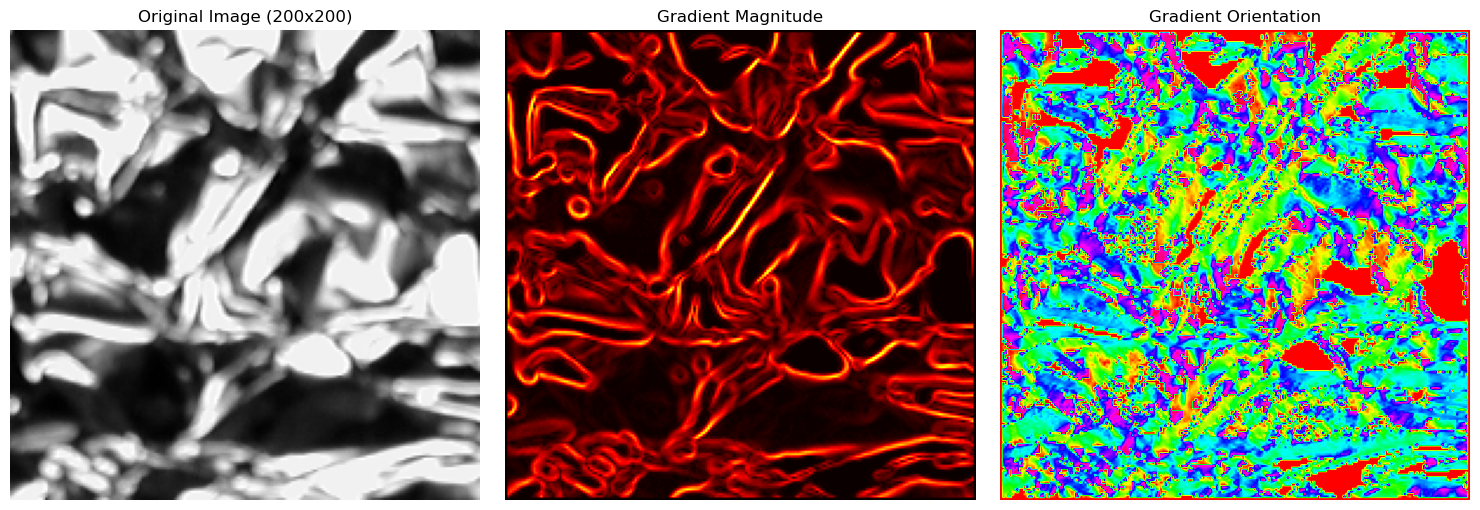

In [ ]:
def compute_hog_features(self, image, orientations=9, pixels_per_cell=(16, 16)):
    """
    Compute Histogram of Oriented Gradients (HOG) from scratch
    Divides image into cells and computes gradient orientation histograms
    """
    height, width = image.shape
    cell_height, cell_width = pixels_per_cell

    # Compute gradients using central difference
    grad_x = np.zeros((height, width))
    grad_y = np.zeros((height, width))

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            grad_x[i, j] = image[i, j+1] - image[i, j-1]
            grad_y[i, j] = image[i+1, j] - image[i-1, j]

    # Compute gradient magnitude and orientation
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    orientation = np.arctan2(grad_y, grad_x) * (180 / math.pi) % 180

    # Calculate number of cells in each dimension
    cells_y = height // cell_height
    cells_x = width // cell_width

    # Initialize HOG features
    hog_features = []
    bin_width = 180 / orientations

    # Compute histogram for each cell
    for i in range(cells_y):
        for j in range(cells_x):
            # Extract cell region
            cell_mag = magnitude[i*cell_height:(i+1)*cell_height,
                               j*cell_width:(j+1)*cell_width]
            cell_ori = orientation[i*cell_height:(i+1)*cell_height,
                                 j*cell_width:(j+1)*cell_width]

            # Compute orientation histogram
            hist = np.zeros(orientations)

            for y in range(cell_height):
                for x in range(cell_width):
                    mag_val = cell_mag[y, x]
                    ori_val = cell_ori[y, x]

                    # Find appropriate orientation bin
                    bin_idx = int(ori_val / bin_width)
                    if bin_idx >= orientations:
                        bin_idx = orientations - 1

                    hist[bin_idx] += mag_val

            hog_features.extend(hist)

    # Normalize HOG features
    hog_features = np.array(hog_features)
    norm = np.linalg.norm(hog_features)
    if norm > 0:
        hog_features = hog_features / norm

    return hog_features, magnitude, orientation

def hog_classification(self, images, labels):
    """
    2(iv): HOG features classification with visualization
    Computes HOG features, visualizes gradients, and trains SVM classifier
    """
    print("2(iv): HOG FEATURES CLASSIFICATION")

    print("Computing HOG features...")
    hog_features = []

    # Extract HOG features for all images
    for i, img in enumerate(images):
        features, _, _ = self.compute_hog_features(img)
        hog_features.append(features)

        if (i + 1) % 20 == 0:
            print(f"  Processed {i + 1}/{len(images)} images")

    X = np.array(hog_features)
    y = labels

    print(f"HOG feature dimensions: {X.shape[1]} features per image")

    # 70-30 train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Standardize and train SVM
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = svm.SVC(kernel='linear', random_state=42)
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")

    # Visualize HOG features for a sample image
    print("\nVisualizing HOG features for a sample image...")
    sample_img = images[0]
    features, magnitude, orientation = self.compute_hog_features(sample_img)

    # Create visualization plot
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(sample_img, cmap='gray')
    plt.title('Original Image (200x200)')
    plt.axis('off')

    # Gradient magnitude
    plt.subplot(1, 3, 2)
    plt.imshow(magnitude, cmap='hot')
    plt.title('Gradient Magnitude')
    plt.axis('off')

    # Gradient orientation
    plt.subplot(1, 3, 3)
    plt.imshow(orientation, cmap='hsv')
    plt.title('Gradient Orientation')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return accuracy

# Add methods to class and execute
TextureClassifier.compute_hog_features = compute_hog_features
TextureClassifier.hog_classification = hog_classification
acc_hog = classifier.hog_classification(images, labels)

PERFORMANCE COMPARISON OF ALL METHODS

METHOD          ACCURACY  
Raw Pixels      0.4239
LBP             0.9383
Bag of Words    0.6790
HOG             0.7942
PERFORMANCE ANALYSIS

1. ACCURACY PERFORMANCE:
   • Highest: LBP (0.9383)
   • Lowest: Raw Pixels (0.4239)


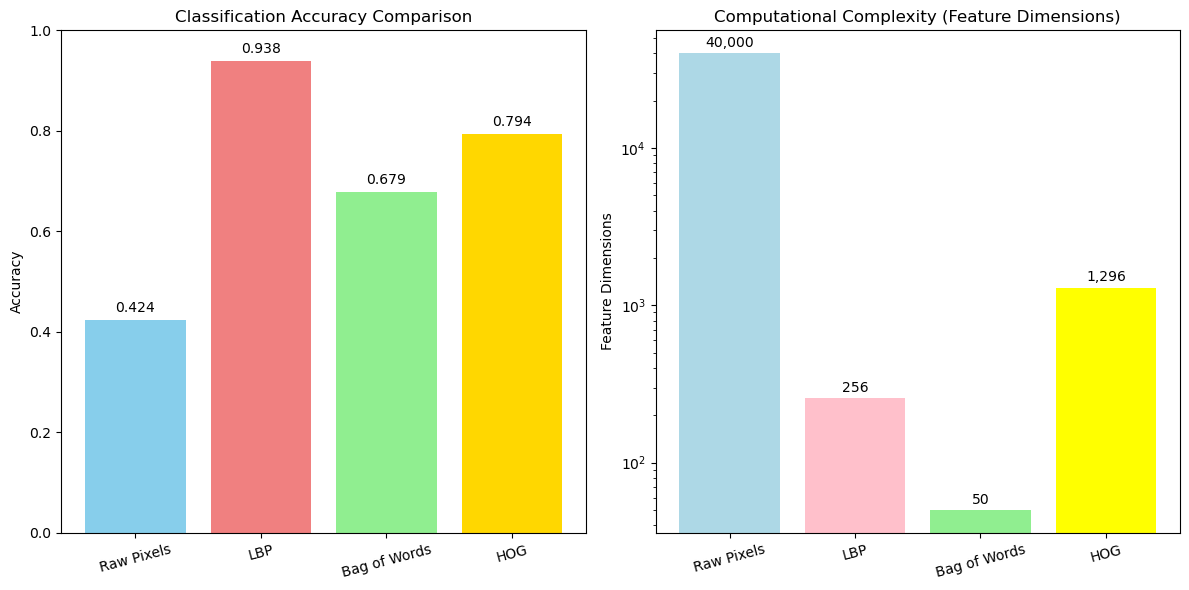

In [ ]:
def compare_performance(self, acc_raw, acc_lbp, acc_bow, acc_hog):
    """
    Compare and contrast performance of all feature extraction methods
    Analyzes accuracy, computational cost, and characteristics of each method
    """
    print("PERFORMANCE COMPARISON OF ALL METHODS")

    # Store results in dictionary
    results = {
        'Raw Pixels': acc_raw,
        'LBP': acc_lbp,
        'Bag of Words': acc_bow,
        'HOG': acc_hog
    }

    # Print accuracy comparison
    print(f"\n{'METHOD':<15} {'ACCURACY':<10}")
    for method, accuracy in results.items():
        print(f"{method:<15} {accuracy:.4f}")

    # Detailed comparison analysis
    print("PERFORMANCE ANALYSIS")

    print("\n1. ACCURACY PERFORMANCE:")
    print(f"   • Highest: {max(results, key=results.get)} ({max(results.values()):.4f})")
    print(f"   • Lowest: {min(results, key=results.get)} ({min(results.values()):.4f})")

    # Create visualization
    methods = list(results.keys())
    accuracies = list(results.values())

    plt.figure(figsize=(12, 6))

    # Accuracy comparison bar chart
    plt.subplot(1, 2, 1)
    bars = plt.bar(methods, accuracies, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    plt.ylim(0, 1)
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy Comparison')
    plt.xticks(rotation=15)

    # Add value labels on bars
    for bar, accuracy in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{accuracy:.3f}', ha='center', va='bottom')

    # Feature dimensionality comparison
    plt.subplot(1, 2, 2)
    dimensions = [40000, 256, 50, 1296]  # Approximate feature dimensions
    bars = plt.bar(methods, dimensions, color=['lightblue', 'pink', 'lightgreen', 'yellow'])
    plt.ylabel('Feature Dimensions')
    plt.title('Computational Complexity (Feature Dimensions)')
    plt.xticks(rotation=15)
    plt.yscale('log')  # Log scale for better visualization

    # Add value labels on bars
    for bar, dim in zip(bars, dimensions):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.05,
                f'{dim:,}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return results

# Execute performance comparison
TextureClassifier.compare_performance = compare_performance
results = classifier.compare_performance(acc_raw, acc_lbp, acc_bow, acc_hog)